In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm

%matplotlib inline

In [2]:
train = pd.read_csv("./Train_SU63ISt.csv", parse_dates=['Datetime'], infer_datetime_format=True)
test = pd.read_csv("./Test_0qrQsBZ.csv", parse_dates=['Datetime'], infer_datetime_format=True)
sample_sub = pd.read_csv("./sample_submission_LSeus50.csv")

train.shape, test.shape, sample_sub.shape

((18288, 3), (5112, 2), (5112, 2))

In [3]:
train.head()

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2


In [4]:
test.head()

,ID,Datetime
0,18288,2014-09-26 00:00:00
1,18289,2014-09-26 01:00:00
2,18290,2014-09-26 02:00:00
3,18291,2014-09-26 03:00:00
4,18292,2014-09-26 04:00:00


In [5]:
sample_sub.head()

,ID,Count
0,18288,0
1,18289,0
2,18290,0
3,18291,0
4,18292,0


### EDA:

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        18288 non-null  int64         
 1   Datetime  18288 non-null  datetime64[ns]
 2   Count     18288 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 428.8 KB


ID is simply the index:

In [7]:
(train.index == train.ID).all()

True

In [8]:
# basic stats
train.describe()

,ID,Count
count,18288.000000,18288.000000
mean,9143.500000,138.958115
std,5279.435197,153.467461
min,0.000000,2.000000
25%,4571.750000,22.000000
50%,9143.500000,84.000000
75%,13715.250000,210.000000
max,18287.000000,1244.000000


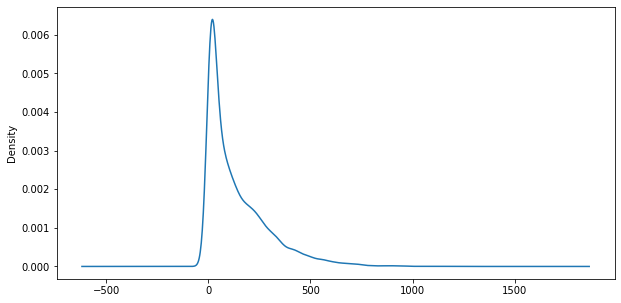

In [9]:
# density of the count column
train.Count.plot(kind="kde", figsize=(10, 5));

In [10]:
# correlation between time and count
train.corr()

,ID,Count
ID,1.000000,0.780628
Count,0.780628,1.000000


Are the dataframes sorted by the datetime columns?

In [11]:
train.Datetime.is_monotonic_increasing, test.Datetime.is_monotonic_increasing

(True, True)

#### Let's visualize the time series with larger strides to simply observe the trends:

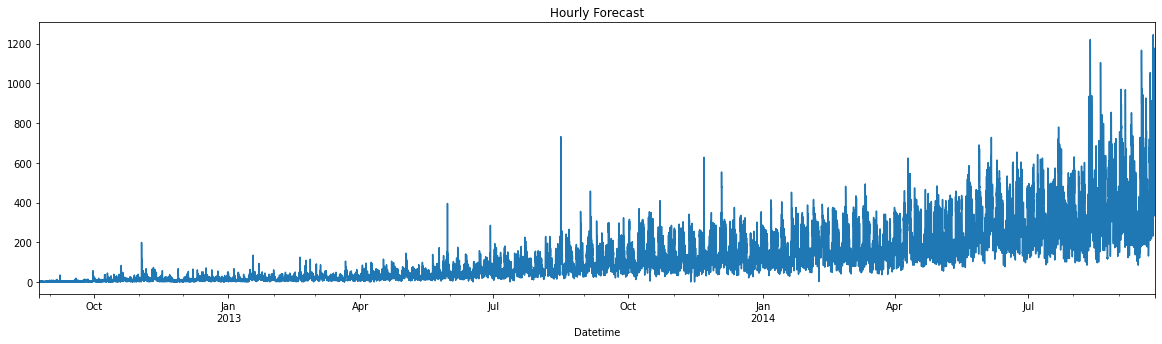

In [12]:
train.set_index("Datetime")["Count"].plot(figsize=(20, 5), title='Hourly Forecast');

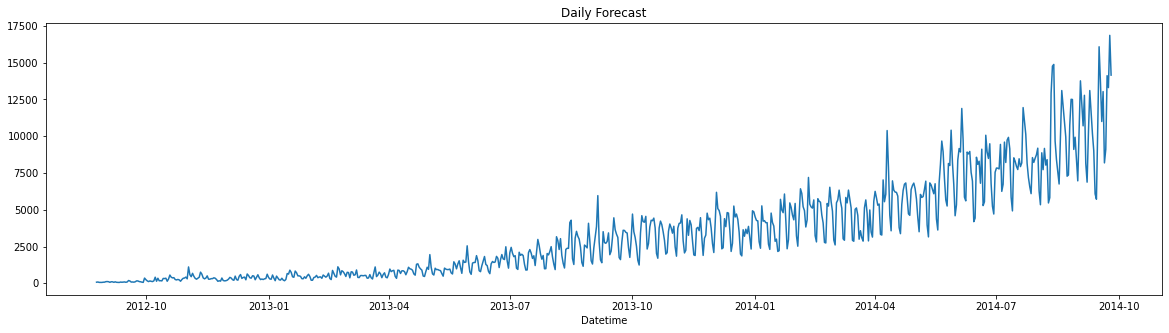

In [13]:
train.groupby(train.Datetime.dt.date)["Count"].sum().plot(figsize=(20, 5), title='Daily Forecast');

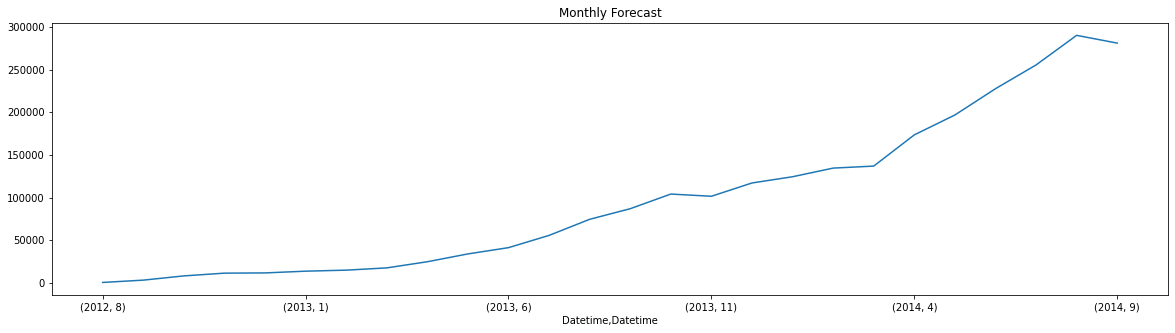

In [14]:
train.groupby([train.Datetime.dt.year, train.Datetime.dt.month])["Count"].sum().plot(figsize=(20, 5), title='Monthly Forecast');

Split the series across the years to get a clearer representation:

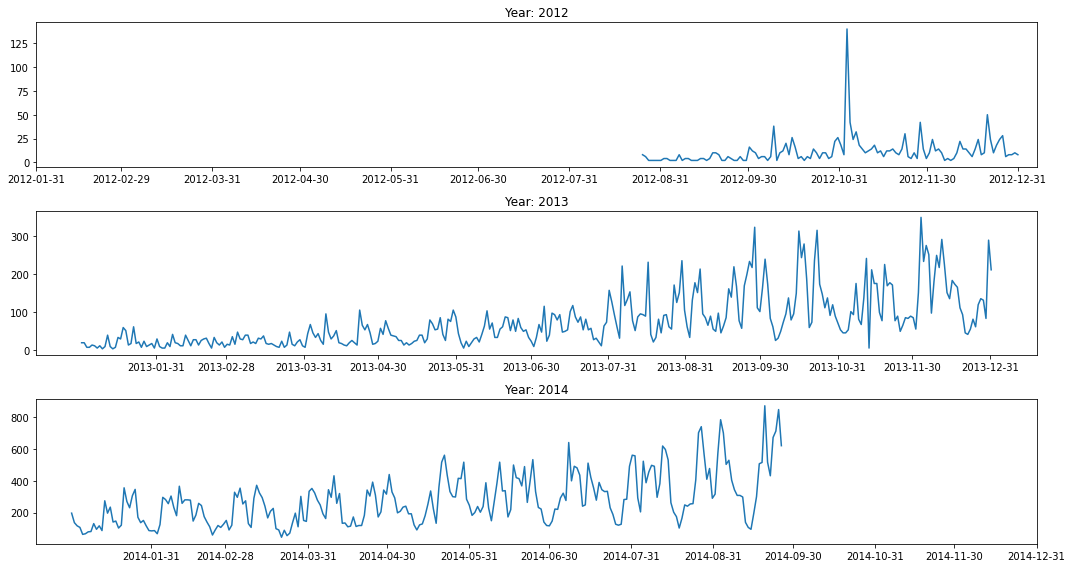

In [15]:
f, ax = plt.subplots(nrows=3, figsize=(15, 8))
for i, year in enumerate(range(2012, 2015)):    
    temp = train.loc[train.Datetime.dt.year == year, ["Datetime", "Count"]]
    ax[i].plot(temp.loc[::25, 'Datetime'], temp.loc[::25, 'Count'])
    ax[i].set(title="Year: " + str(year), xticks=pd.date_range(str(year), str(year + 1), freq='M'))

plt.tight_layout()

The duration for which we are to predict the counts is from the month of date of `26-09-2014` to `26-04-2015`, for 7 months, spanning across 2 years:

In [16]:
test.Datetime.min(), test.Datetime.max()

(Timestamp('2014-09-26 00:00:00'), Timestamp('2015-04-26 23:00:00'))

Let's make a lag plot to see how various lag features are corelated with the `Count` target:

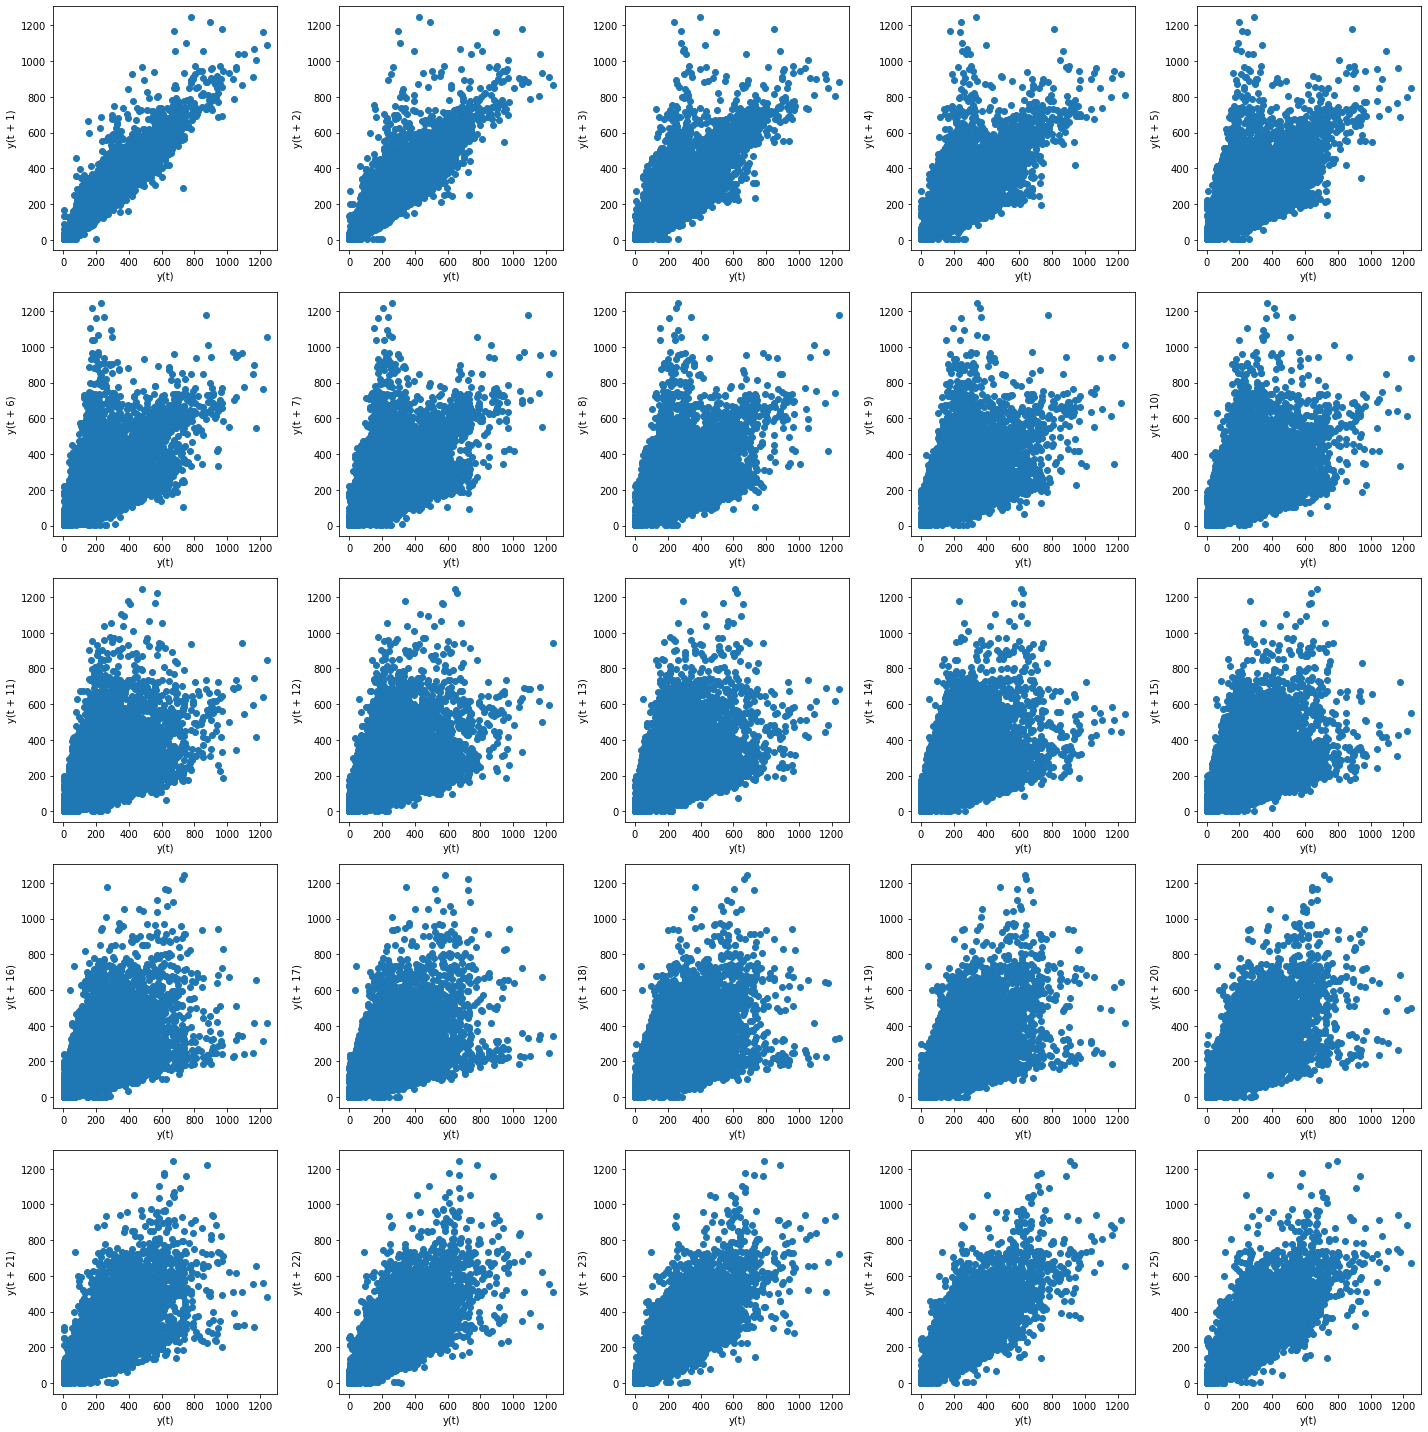

In [17]:
f, ax = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
ax = ax.ravel()

for i in range(25):
    pd.plotting.lag_plot(train.Count, lag=i+1, ax=ax[i])
    
plt.tight_layout()

We observe that for lower values, there is a strong corelation however with higher values the corelation sharply declines.


Let's make an autocorelation plot to study it all in one graph:

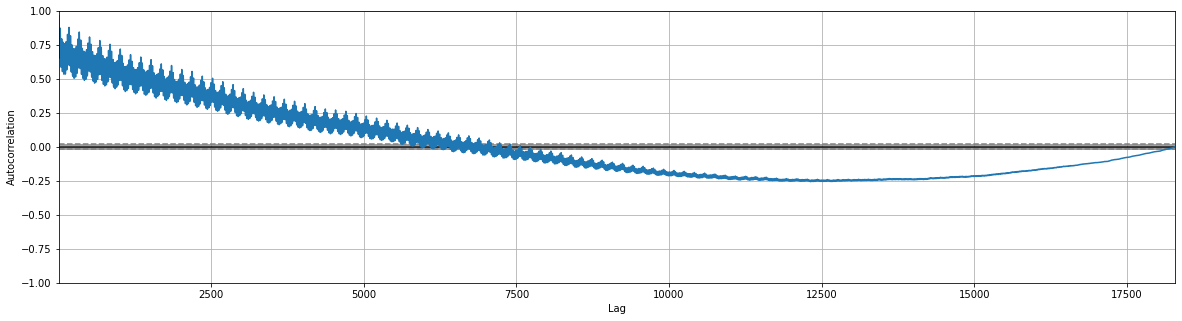

In [18]:
plt.figure(figsize=(20, 5))
pd.plotting.autocorrelation_plot(train.Count);

#### Let's try to model the data ourself and see which value of x best captures the trend:

In [19]:
temp = pd.DataFrame(train.Count)
for i in tqdm.tqdm(np.linspace(0, 25, 100)):
    temp[f'{i}**x'] = (i ** np.linspace(0, 1, 18288))

print ()
print (temp.corr()["Count"].abs().sort_values(ascending=False).iloc[1:5+1])
del temp

100%|██████████| 100/100 [00:00<00:00, 434.16it/s]



15.151515151515152**x    0.823178
15.404040404040405**x    0.823177
14.8989898989899**x      0.823176
15.656565656565657**x    0.823174
14.646464646464647**x    0.823172
Name: Count, dtype: float64


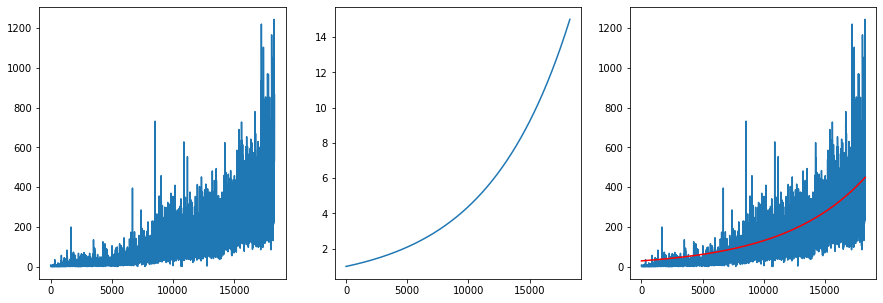

In [20]:
f, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].plot(train.Count)
ax[1].plot(15 ** np.linspace(0, 1, train.shape[0]))
ax[2].plot(train.Count)
ax[2].plot(15 ** np.linspace(0, 1, train.shape[0]) * 30, color='red')

An exp value of 15 best captures the trend!

Let's merge the Test and Train datasets together and generate lag features and meta features out of the datetime:

In [21]:
data = pd.concat([train, test]).reset_index(drop=True)
data.head()

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8.0
1,1,2012-08-25 01:00:00,2.0
2,2,2012-08-25 02:00:00,6.0
3,3,2012-08-25 03:00:00,2.0
4,4,2012-08-25 04:00:00,2.0


In [22]:
data['Year'] = data.Datetime.dt.year
data['Month'] = data.Datetime.dt.month
data['Week'] = data.Datetime.dt.weekofyear
data['Weekday'] = data.Datetime.dt.weekday
data['Day'] = data.Datetime.dt.day
data['Hour'] = data.Datetime.dt.hour
data['Is_Night'] = data.Hour // 12
data['Month_begin'] = data.Datetime.dt.is_month_start

Let's also add a `exp` and a `diff` feature that captures the distribution to help our model learn the trend:

In [23]:
data["exp"] = 15 ** np.linspace(0, 1, data.shape[0])
data["Diff"] = data["ID"]
data.head()

,ID,Datetime,Count,Year,Month,Week,Weekday,Day,Hour,Is_Night,Month_begin,exp,Diff
0,0,2012-08-25 00:00:00,8.0,2012,8,34,5,25,0,0,False,1.000000,0
1,1,2012-08-25 01:00:00,2.0,2012,8,34,5,25,1,0,False,1.000116,1
2,2,2012-08-25 02:00:00,6.0,2012,8,34,5,25,2,0,False,1.000231,2
3,3,2012-08-25 03:00:00,2.0,2012,8,34,5,25,3,0,False,1.000347,3
4,4,2012-08-25 04:00:00,2.0,2012,8,34,5,25,4,0,False,1.000463,4


We need to predict data for 7 months (7 * 31 * 24 = 5113 apprx). Since this data is hourly data we need to shift by 5113 values or greater to generate lag features for all the rows in test dataset.

In [24]:
temp = ((test.Datetime.max() - test.Datetime.min())).total_seconds()

print ("Values to shift by:\n")
print ("=> Hours to shift:", temp / 3600)
print ("=> Days to shift:", temp / (3600 * 24))
print ("=> Weeks to shift:", temp / (3600 * 24 * 7))
print ("=> Months to shift:", temp / (3600 * 24 * 31))

Values to shift by:

=> Hours to shift: 5111.0
=> Days to shift: 212.95833333333334
=> Weeks to shift: 30.422619047619047
=> Months to shift: 6.869623655913978


Before we create the lag features however, let's create some more features totalling counts for each day, month, weekday etc.

In [25]:
n_lag_features = 5
for groupby, lag in zip([['Month'], ['Week'], ['Month', 'Day']], [7, 31, 213]):
    new_col_name = f"{groupby[-1]}_Total"
    temp = data.groupby(by=['Year', *groupby], as_index=False)['Count'].sum().rename({"Count": new_col_name}, axis=1)
    
    for i in range(lag, lag+5):
        temp[f"{new_col_name}_lag_{i}"] = temp[new_col_name].shift(i)
        
    # while we need the lag features, we don't need the features themselves
    # data = data.merge(temp.drop(new_col_name, axis=1), on=['Year', *groupby])  
    data = data.merge(temp, on=['Year', *groupby], how='left')
    
# let's remove and append these columns at the end
columns = data.columns.to_list()

# at_end = ["Count"]
at_end = ['Month_Total', 'Week_Total', 'Day_Total', 'Count']
for col in at_end:
    columns.remove(col)

data = data[columns + at_end]

# fill in the missing cells as 0
data.fillna(0.0, inplace=True)

# sort the dataframe before split
data.sort_values(by='Datetime', inplace=True)

# shape of dataframe
data.shape

(23400, 31)

In [26]:
# all ok?
data.columns

Index(['ID', 'Datetime', 'Year', 'Month', 'Week', 'Weekday', 'Day', 'Hour',
       'Is_Night', 'Month_begin', 'exp', 'Diff', 'Month_Total_lag_7',
       'Month_Total_lag_8', 'Month_Total_lag_9', 'Month_Total_lag_10',
       'Month_Total_lag_11', 'Week_Total_lag_31', 'Week_Total_lag_32',
       'Week_Total_lag_33', 'Week_Total_lag_34', 'Week_Total_lag_35',
       'Day_Total_lag_213', 'Day_Total_lag_214', 'Day_Total_lag_215',
       'Day_Total_lag_216', 'Day_Total_lag_217', 'Month_Total', 'Week_Total',
       'Day_Total', 'Count'],
      dtype='object')

Let's normalise the dataframe columns:

1. Ordinal Enc: Year
2. Min-max normalization: 'Month', 'Week', 'Weekday', 'Day', 'Hour'
3. Z score Normalize: The rest


In [27]:
def preprocess(x):
    '''A function to preprocess the dataframe columns as required.'''
    
    if x.name in ["ID", "Datetime"]:
        return x
    
    if x.name == 'Year':
        op = x.astype("category").cat.codes
    
    elif x.name in ["Is_Night", "Month_begin", "exp", "Count"]:
        op = x
    
    elif x.name in ['Month', 'Week', 'Weekday', 'Day', 'Hour', 'Diff']:
        op = x / x.max()
    
    else:
        op = (x - x.mean()) / x.std()
        
    return op.astype(np.float32)

In [28]:
data = data.apply(preprocess)
data.head()

,ID,Datetime,Year,Month,Week,Weekday,Day,Hour,Is_Night,Month_begin,exp,Diff,Month_Total_lag_7,Month_Total_lag_8,Month_Total_lag_9,Month_Total_lag_10,Month_Total_lag_11,Week_Total_lag_31,Week_Total_lag_32,Week_Total_lag_33,Week_Total_lag_34,Week_Total_lag_35,Day_Total_lag_213,Day_Total_lag_214,Day_Total_lag_215,Day_Total_lag_216,Day_Total_lag_217,Month_Total,Week_Total,Day_Total,Count
0,0,2012-08-25 00:00:00,0.0,0.666667,0.653846,0.833333,0.806452,0.000000,0.0,0.0,1.000000,0.000000,-0.88205,-0.849987,-0.83315,-0.814754,-0.795377,-0.857272,-0.856987,-0.849059,-0.84697,-0.843518,-0.815947,-0.816621,-0.819435,-0.819733,-0.8206,-0.882144,-0.866298,-0.792155,8.0
1,1,2012-08-25 01:00:00,0.0,0.666667,0.653846,0.833333,0.806452,0.043478,0.0,0.0,1.000116,0.000043,-0.88205,-0.849987,-0.83315,-0.814754,-0.795377,-0.857272,-0.856987,-0.849059,-0.84697,-0.843518,-0.815947,-0.816621,-0.819435,-0.819733,-0.8206,-0.882144,-0.866298,-0.792155,2.0
2,2,2012-08-25 02:00:00,0.0,0.666667,0.653846,0.833333,0.806452,0.086957,0.0,0.0,1.000232,0.000085,-0.88205,-0.849987,-0.83315,-0.814754,-0.795377,-0.857272,-0.856987,-0.849059,-0.84697,-0.843518,-0.815947,-0.816621,-0.819435,-0.819733,-0.8206,-0.882144,-0.866298,-0.792155,6.0
3,3,2012-08-25 03:00:00,0.0,0.666667,0.653846,0.833333,0.806452,0.130435,0.0,0.0,1.000347,0.000128,-0.88205,-0.849987,-0.83315,-0.814754,-0.795377,-0.857272,-0.856987,-0.849059,-0.84697,-0.843518,-0.815947,-0.816621,-0.819435,-0.819733,-0.8206,-0.882144,-0.866298,-0.792155,2.0
4,4,2012-08-25 04:00:00,0.0,0.666667,0.653846,0.833333,0.806452,0.173913,0.0,0.0,1.000463,0.000171,-0.88205,-0.849987,-0.83315,-0.814754,-0.795377,-0.857272,-0.856987,-0.849059,-0.84697,-0.843518,-0.815947,-0.816621,-0.819435,-0.819733,-0.8206,-0.882144,-0.866298,-0.792155,2.0


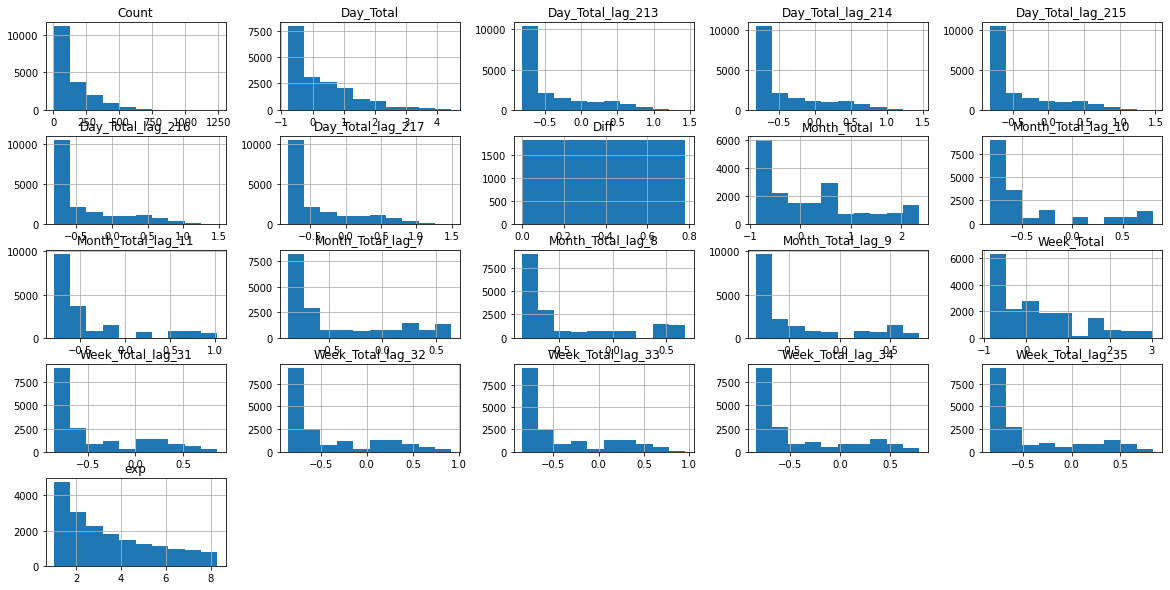

In [29]:
pd.plotting.hist_frame(data.iloc[:18288, 10:], figsize=(20, 10));

#### Let's do a train/Val split on the dataset:

In [30]:
train.Datetime.min(), train.Datetime.max(), test.Datetime.min(), test.Datetime.max()

(Timestamp('2012-08-25 00:00:00'),
 Timestamp('2014-09-25 23:00:00'),
 Timestamp('2014-09-26 00:00:00'),
 Timestamp('2015-04-26 23:00:00'))

In [31]:
# train dataset
Train = data[(data.Datetime < '2014-08-01 00:00:00')]

# val dataset
Val = data[(data.Datetime >= '2014-08-01 00:00:00') & (data.Datetime < '2014-09-26 00:00:00')]

# test dataset
Test = data[(data.Datetime >= '2014-09-26 00:00:00')]

Train.shape, Val.shape, Test.shape

((16944, 31), (1344, 31), (5112, 31))

#### How does the prospect look?

Let's check for the corelations for train and val dataset which hopefully would be reflected into the test dataset:

In [32]:
pd.concat([Train, Val]).corr()['Count'].abs().sort_values(ascending=False).iloc[:5]

Count          1.000000
Day_Total      0.885047
Week_Total     0.827246
exp            0.821352
Month_Total    0.820260
Name: Count, dtype: float64

In [33]:
Train.corr()["Count"].abs().sort_values(ascending=False).iloc[:5]

Count          1.000000
Day_Total      0.886317
Week_Total     0.830187
Month_Total    0.824657
exp            0.820259
Name: Count, dtype: float64

In [34]:
Val.corr()['Count'].abs().sort_values(ascending=False).iloc[:5]

Count        1.000000
Day_Total    0.574292
Is_Night     0.479230
Hour         0.466844
Weekday      0.390388
Name: Count, dtype: float64

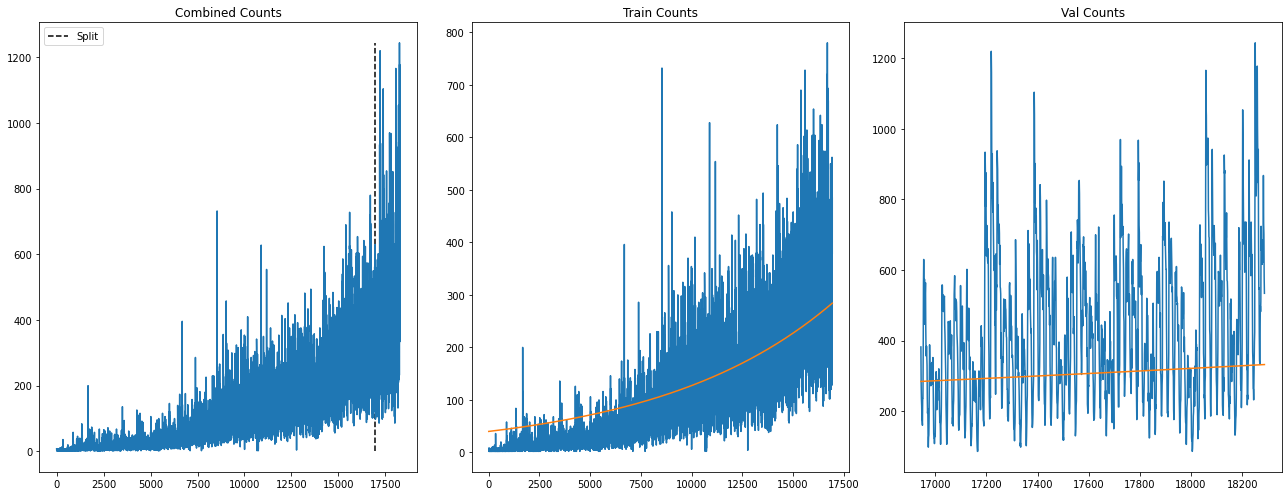

In [35]:
f, ax = plt.subplots(ncols=3, figsize=(18, 7))
ax[0].plot(pd.concat([Train.Count, Val.Count]))
ax[0].vlines(len(Train.Count), 0, data.Count.max(), linestyles='dashed', label='Split')
ax[0].legend()
ax[0].set(title="Combined Counts")
ax[1].plot(Train.Count)
ax[1].plot(40 * Train.exp)
ax[1].set_title("Train Counts")
ax[2].plot(Val.Count)
ax[2].plot(40 * Val.exp)
ax[2].set_title("Val Counts")

plt.tight_layout();

### Lets create a Tf dataset to train our model on:

In [36]:
def split_data_to_XY(x, univariate=True):
    
    if univariate:
        op = (x[:-4], x[-1])
    else:
        op = (x[:-4], (x[-4], x[-3], x[-2], x[-1]))

    return op

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices(Train.iloc[:, 2:].values).map(split_data_to_XY)
train_dataset = train_dataset.batch(32).shuffle(500).repeat().prefetch(1)

val_dataset = tf.data.Dataset.from_tensor_slices(Val.iloc[:, 2:].values).map(split_data_to_XY)
val_dataset = val_dataset.batch(32).prefetch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(Test.iloc[:, 2:].values).map(split_data_to_XY)
test_dataset = test_dataset.batch(32)

In [38]:
next(iter(train_dataset));
next(iter(test_dataset));
next(iter(val_dataset));

In [39]:
temp = next(iter(train_dataset))
temp[0][:4], temp[1][:4]

(<tf.Tensor: shape=(4, 25), dtype=float32, numpy=
 array([[ 2.        ,  0.33333334,  0.32692307,  0.6666667 ,  0.8064516 ,
          0.        ,  0.        ,  0.        ,  5.412897  ,  0.6236164 ,
          0.10312539,  0.06703877, -0.06286386, -0.17243217, -0.2015684 ,
          0.16297211,  0.11603272,  0.2299232 ,  0.06414934,  0.11992108,
          0.31291848,  0.0611504 , -0.3070143 , -0.25958273,  0.18545254],
        [ 2.        ,  0.33333334,  0.32692307,  0.6666667 ,  0.8064516 ,
          0.04347826,  0.        ,  0.        ,  5.4135237 ,  0.62365913,
          0.10312539,  0.06703877, -0.06286386, -0.17243217, -0.2015684 ,
          0.16297211,  0.11603272,  0.2299232 ,  0.06414934,  0.11992108,
          0.31291848,  0.0611504 , -0.3070143 , -0.25958273,  0.18545254],
        [ 2.        ,  0.33333334,  0.32692307,  0.6666667 ,  0.8064516 ,
          0.08695652,  0.        ,  0.        ,  5.41415   ,  0.6237019 ,
          0.10312539,  0.06703877, -0.06286386, -0.17243217,

Let's create a simple model comprising wholy of dense layers before we go with LSTM's:

In [40]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(25,)),
    tf.keras.layers.Dense(96, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(96, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(96, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(96, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', metrics=['mse', 'mae'], optimizer=tf.keras.optimizers.Nadam(0.01))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                2496      
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_2 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_3 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 97        
Total params: 30,529
Trainable params: 30,529
Non-trainable params: 0
_________________________________________________________________


In [41]:
train_steps = len(Train) // 32
val_steps = len(Val) // 32

hist = model.fit(
    train_dataset, epochs=60, steps_per_epoch=train_steps, 
    validation_data=val_dataset, validation_steps=val_steps,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_mse', patience=10, 
            restore_best_weights=True, mode='min'),

        tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5)
    ]
)

Epoch 1/60
529/529 [==============================] - 1s 2ms/step - loss: 6708.8213 - mse: 6708.8213 - mae: 51.2429 - val_loss: 43301.2422 - val_mse: 43301.2422 - val_mae: 152.3568 - lr: 0.0100
Epoch 2/60
529/529 [==============================] - 2s 3ms/step - loss: 3998.8765 - mse: 3998.8765 - mae: 39.7184 - val_loss: 25788.2793 - val_mse: 25788.2793 - val_mae: 121.6578 - lr: 0.0100
Epoch 3/60
529/529 [==============================] - 2s 3ms/step - loss: 3067.3032 - mse: 3067.3032 - mae: 35.1853 - val_loss: 29910.7715 - val_mse: 29910.7715 - val_mae: 126.7792 - lr: 0.0100
Epoch 4/60
529/529 [==============================] - 2s 3ms/step - loss: 2939.7141 - mse: 2939.7141 - mae: 34.2936 - val_loss: 50067.0195 - val_mse: 50067.0195 - val_mae: 165.9912 - lr: 0.0100
Epoch 5/60
529/529 [==============================] - 2s 3ms/step - loss: 3004.8643 - mse: 3004.8643 - mae: 34.7479 - val_loss: 34058.2539 - val_mse: 34058.2539 - val_mae: 133.2245 - lr: 0.0100
Epoch 6/60
529/529 [==========

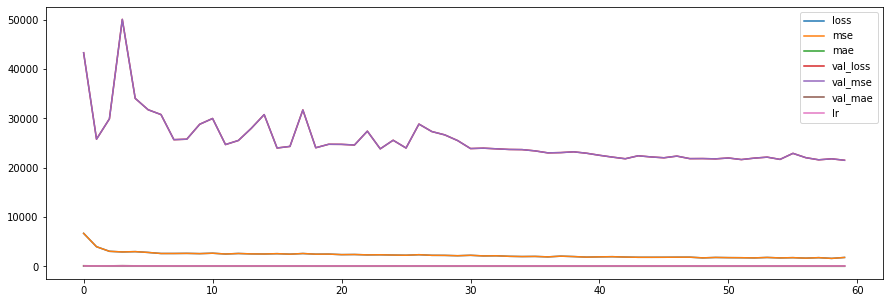

In [42]:
pd.DataFrame(hist.history).plot(figsize=(15, 5));

In [43]:
preds = model.predict(test_dataset)
preds.shape

(5112, 1)

In [44]:
Test["Count"] = preds

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Let's see how well our model has performed by visualising the output:

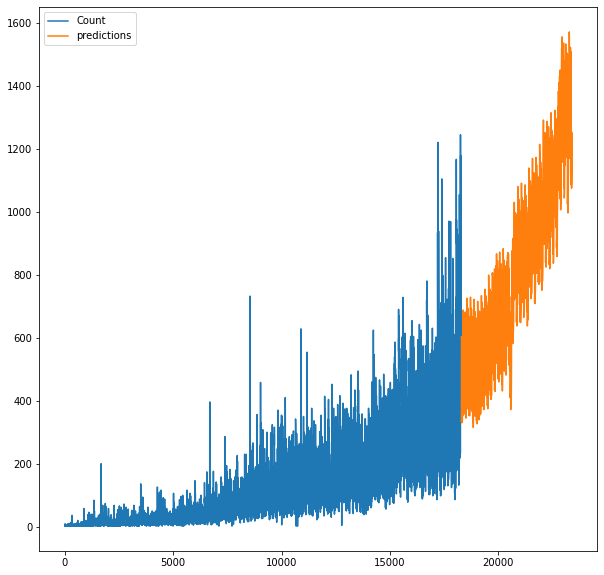

In [45]:
pd.concat([Train, Val])["Count"].plot(figsize=(10, 10))
Test.Count.plot(label='predictions')
plt.legend();

In [46]:
Test.sort_values(by='Datetime')[["ID", "Count"]].to_csv("Dense_Sub.csv", index=False)

Let's now modify the dataset and perform multivariate time series predictions:

In [47]:
train_dataset = tf.data.Dataset.from_tensor_slices(Train.iloc[:, 2:].values).map(lambda x: split_data_to_XY(x, univariate=False))
train_dataset = train_dataset.batch(32).shuffle(500).repeat().prefetch(1)

val_dataset = tf.data.Dataset.from_tensor_slices(Val.iloc[:, 2:].values).map(lambda x: split_data_to_XY(x, univariate=False))
val_dataset = val_dataset.batch(32).prefetch(1)

test_dataset = tf.data.Dataset.from_tensor_slices(Test.iloc[:, 2:].values).map(lambda x: split_data_to_XY(x, univariate=False))
test_dataset = test_dataset.batch(32)

next(iter(train_dataset))
next(iter(val_dataset))
next(iter(test_dataset));

In [48]:
temp = next(iter(train_dataset))
temp[0][:4], temp[1][:4]

(<tf.Tensor: shape=(4, 25), dtype=float32, numpy=
 array([[ 0.        ,  0.6666667 ,  0.6730769 ,  0.6666667 ,  1.        ,
          0.6956522 ,  1.        ,  0.        ,  1.0186899 ,  0.0068379 ,
         -0.8820503 , -0.8499869 , -0.8331502 , -0.8147541 , -0.79537743,
         -0.85727173, -0.85698724, -0.8490591 , -0.8469702 , -0.84351844,
         -0.81594723, -0.81662065, -0.81943494, -0.819733  , -0.8206002 ],
        [ 0.        ,  0.6666667 ,  0.6730769 ,  0.6666667 ,  1.        ,
          0.73913044,  1.        ,  0.        ,  1.0188078 ,  0.00688064,
         -0.8820503 , -0.8499869 , -0.8331502 , -0.8147541 , -0.79537743,
         -0.85727173, -0.85698724, -0.8490591 , -0.8469702 , -0.84351844,
         -0.81594723, -0.81662065, -0.81943494, -0.819733  , -0.8206002 ],
        [ 0.        ,  0.6666667 ,  0.6730769 ,  0.6666667 ,  1.        ,
          0.7826087 ,  1.        ,  0.        ,  1.0189257 ,  0.00692337,
         -0.8820503 , -0.8499869 , -0.8331502 , -0.8147541 ,

### Model \#2:
Let's create our model and train it on the monthly, weekly and daily sales as well to see if we can improve its performance:

In [252]:
# clear memory
tf.keras.backend.clear_session()

inp = tf.keras.layers.Input(shape=(25,), name='Input_Layer')
hidden0 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(inp)
hidden1 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(hidden0)
intermediate0 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(hidden1)

monthly_op = tf.keras.layers.Dense(1, name='Monthly_Count')(intermediate0)

hidden2 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(intermediate0)
hidden3 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(hidden2)
intermediate1 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(hidden3)

weekly_op = tf.keras.layers.Dense(1, name='Weekly_Count')(intermediate1)

hidden4 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(intermediate1)
hidden5 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(hidden4)
intermediate2 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(hidden5)

daily_op = tf.keras.layers.Dense(1, name='Daily_Count')(intermediate2)

concat = tf.keras.layers.Concatenate(name='C_with_rest')([inp, daily_op, weekly_op, monthly_op])
hidden6 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(concat)
hidden7 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(hidden6)
hidden8 = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal')(hidden7)
intermediate3 = tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal')(hidden8)

final_op = tf.keras.layers.Dense(1, name='Hourly_Count')(intermediate3)

# create them layers!
model = tf.keras.models.Model(inputs=inp, outputs=[monthly_op, weekly_op, daily_op, final_op])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 25)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           1664        Input_Layer[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
______________________________________________________________________________________________

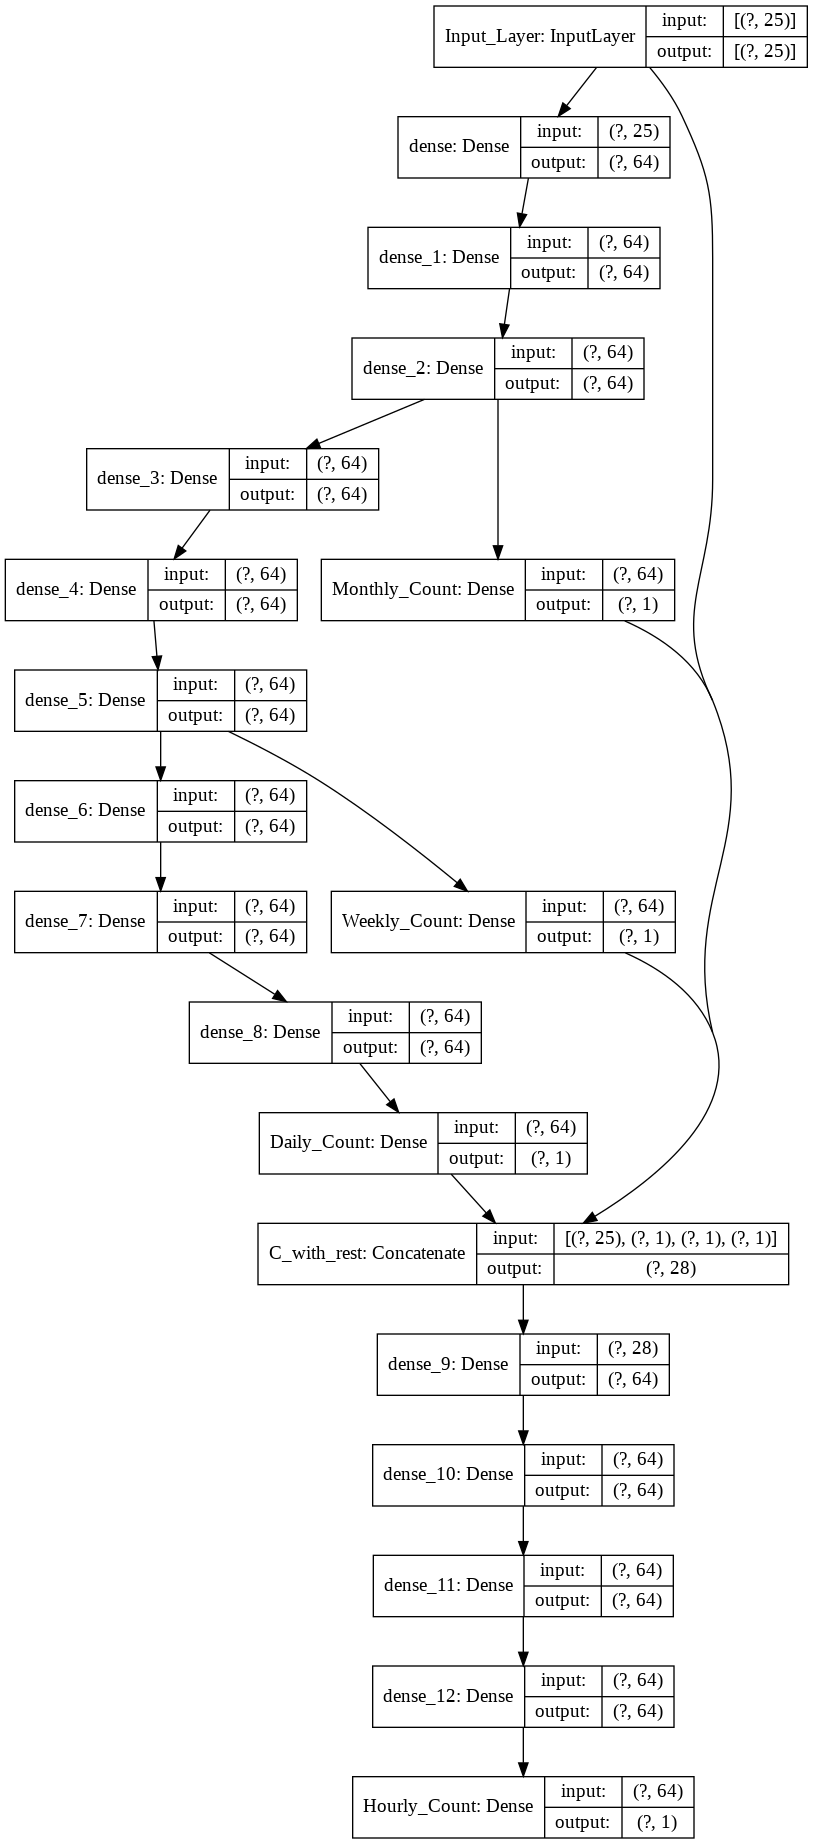

In [253]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [254]:
model.compile(
    loss='mse', 
    optimizer=tf.keras.optimizers.Nadam(0.005),
    loss_weights=[0.2, 0.3, 0.4, 1])

In [255]:
train_steps = len(Train) // 32
val_steps = len(Val) // 32

hist = model.fit(
    train_dataset, epochs=100, steps_per_epoch=train_steps, 
    validation_data=val_dataset, validation_steps=val_steps,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_Hourly_Count_loss', patience=15, 
            restore_best_weights=True, mode='min'),

        tf.keras.callbacks.ReduceLROnPlateau(
            patience=5, factor=0.5, monitor='val_Hourly_Count_loss')
    ]
)

Epoch 1/100
529/529 [==============================] - 2s 4ms/step - loss: 5517.2192 - Monthly_Count_loss: 79.3159 - Weekly_Count_loss: 11.2538 - Daily_Count_loss: 89.7249 - Hourly_Count_loss: 5462.0933 - val_loss: 37969.0391 - val_Monthly_Count_loss: 96.7614 - val_Weekly_Count_loss: 3.3397 - val_Daily_Count_loss: 26.3693 - val_Hourly_Count_loss: 37938.1328 - lr: 0.0050
Epoch 2/100
529/529 [==============================] - 3s 5ms/step - loss: 3595.4465 - Monthly_Count_loss: 15.9454 - Weekly_Count_loss: 0.7337 - Daily_Count_loss: 5.1416 - Hourly_Count_loss: 3589.9800 - val_loss: 27734.9609 - val_Monthly_Count_loss: 63.4610 - val_Weekly_Count_loss: 4.7386 - val_Daily_Count_loss: 7.7707 - val_Hourly_Count_loss: 27717.7344 - lr: 0.0050
Epoch 3/100
529/529 [==============================] - 3s 5ms/step - loss: 3413.6111 - Monthly_Count_loss: 13.5692 - Weekly_Count_loss: 0.6502 - Daily_Count_loss: 0.8047 - Hourly_Count_loss: 3410.3813 - val_loss: 34478.3555 - val_Monthly_Count_loss: 24.5972

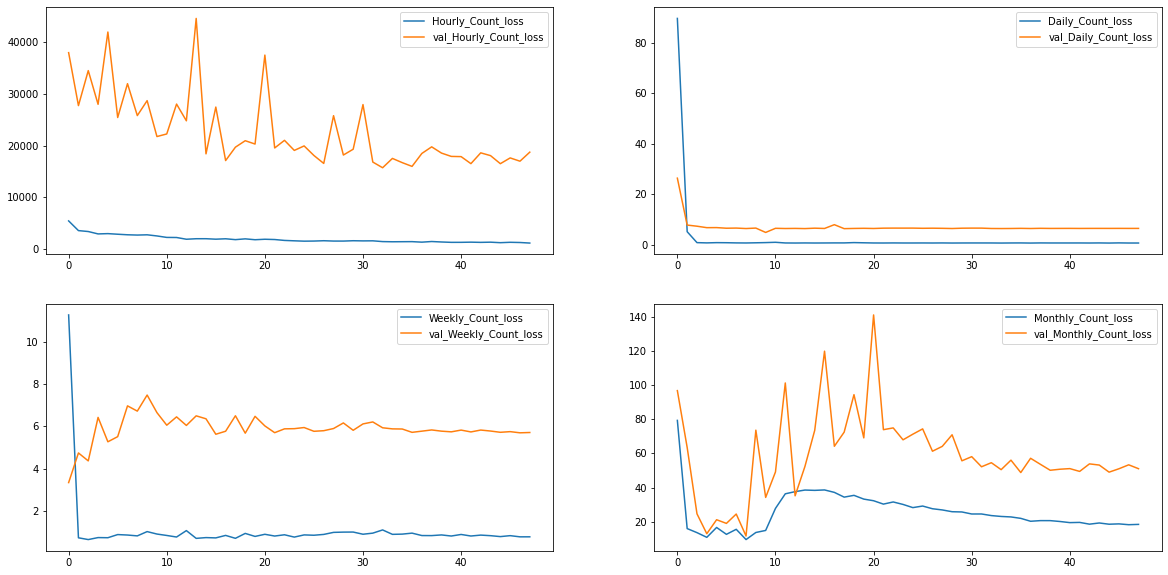

In [256]:
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
ax = ax.ravel()
pd.DataFrame(hist.history).loc[:, ['Hourly_Count_loss', "val_Hourly_Count_loss"]].plot(ax=ax[0]);
pd.DataFrame(hist.history).loc[:, ['Daily_Count_loss', "val_Daily_Count_loss"]].plot(ax=ax[1]);
pd.DataFrame(hist.history).loc[:, ['Weekly_Count_loss', "val_Weekly_Count_loss"]].plot(ax=ax[2]);
pd.DataFrame(hist.history).loc[:, ['Monthly_Count_loss', "val_Monthly_Count_loss"]].plot(ax=ax[3]);

#### Let's make the submissions:

In [257]:
test_steps = np.ceil(len(Test) / 32)
preds = model.predict(test_dataset, steps=test_steps)
Test['Count'] = preds[-1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [258]:
Train.iloc[:, -4:].tail()

,Month_Total,Week_Total,Day_Total,Count
16939,1.970051,1.747924,1.920128,462.0
16940,1.970051,1.747924,1.920128,464.0
16941,1.970051,1.747924,1.920128,408.0
16942,1.970051,1.747924,1.920128,378.0
16943,1.970051,1.747924,1.920128,484.0


In [259]:
Test.iloc[:, -4:].head()

,Month_Total,Week_Total,Day_Total,Count
18288,2.256479,1.921211,-0.815947,410.108704
18289,2.256479,1.921211,-0.815947,368.474152
18290,2.256479,1.921211,-0.815947,327.256134
18291,2.256479,1.921211,-0.815947,282.975372
18292,2.256479,1.921211,-0.815947,262.900787


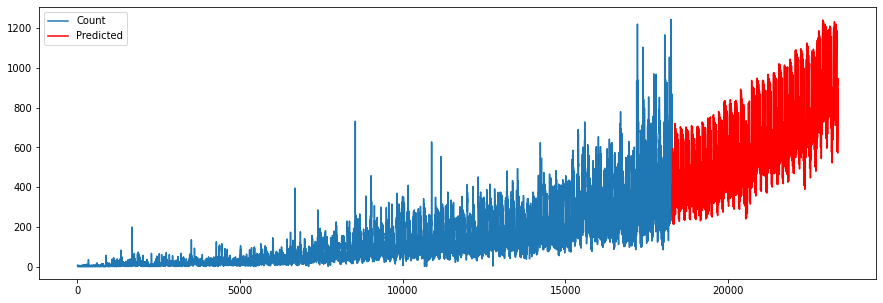

In [260]:
pd.concat([Train, Val]).sort_values("Datetime").loc[:, ['Count']].plot(figsize=(15, 5))
Test.Count.plot(color='red', label='Predicted')
plt.legend();

In [262]:
(test.merge(
    Test.sort_values(by='Datetime')[['Datetime', 'Count']], 
    on='Datetime')
 
 # let's save the submission
 .drop("Datetime", axis=1).to_csv("submission.csv", index=False))